Poisson Equation Solver for BOS Data
(using Direct solver with spatially-varying Dirichlet boundary conditions)

Loading data from: bos_pixel_displacements.txt
Loading BOS data from: bos_pixel_displacements.txt
Detected grid size: 51 x 51
X range: [-0.002500, 0.002500] m
Y range: [-0.002500, 0.002500] m
Grid spacing: hx = 1.000000e-04 m, hy = 1.000000e-04 m
Displacement field loaded successfully!
  Δx_pixels range: [-0.4707, 0.4707]
  Δy_pixels range: [-0.4707, 0.4707]

Grid parameters:
  Nx = 51, Ny = 51
  Grid spacing h = 1.000000e-04 m

Physical parameters:
  n₀ = 1.0
  G = 0.00026 m³/kg
  ψ = 99999.99999999999 m
  M = 0.1166
  z_D = 0.25 m

Computed spatially-varying boundary conditions from Gaussian density field:
  Thickness = 0.01 m
  Left boundary (x=-0.002500):   ρ ranges [0.013273, 0.014002]
  Right boundary (x=0.002500):  ρ ranges [0.013273, 0.014002]
  Bottom boundary (y=-0.002500): ρ ranges [0.013273, 0.014002]
  Top boundary (y=0.002500):    ρ ranges [0.013273, 0.014002]


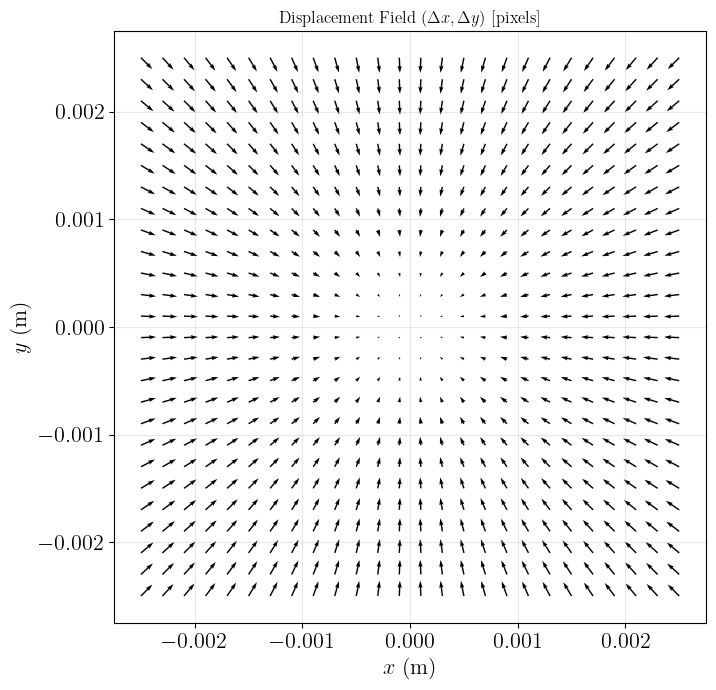

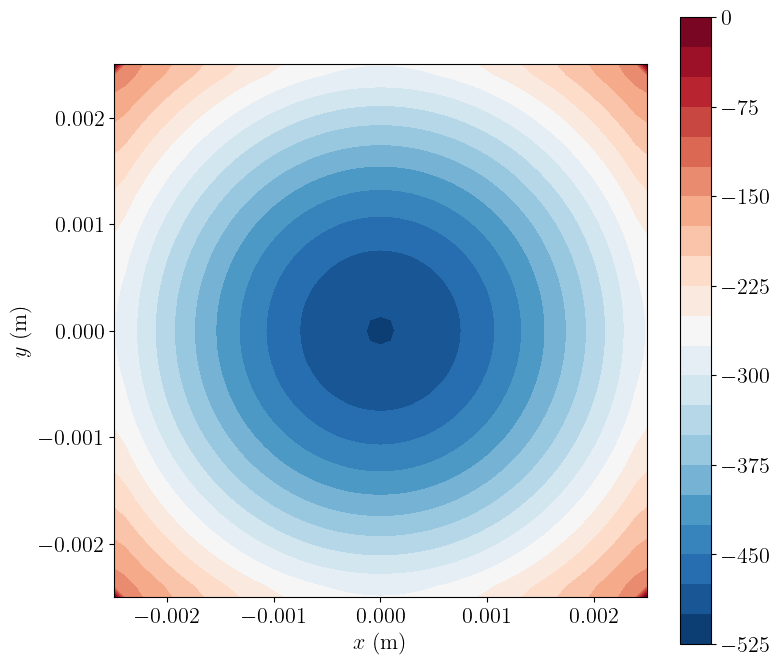

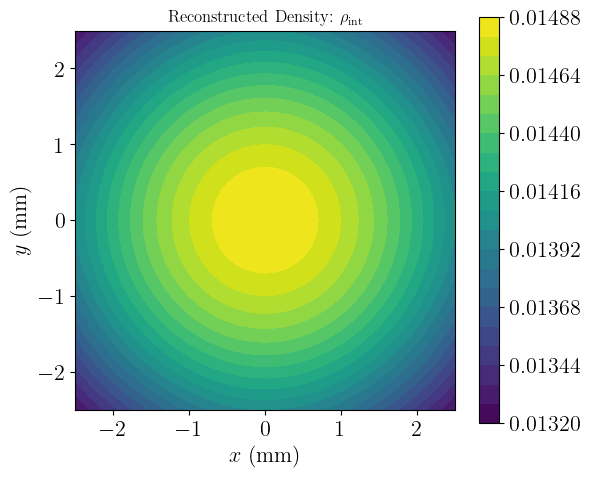

Density field saved to density_field.txt

Processing completed!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, lil_matrix
from scipy.sparse.linalg import spsolve
import time
import argparse

plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{bm}'

# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 14


class PoissonSolverDirect:
    """
    Solves the Poisson equation using Direct solver (sparse LU decomposition)
    ∇²ρ = RHS where RHS = (n₀/(G·ψ·M·z_D)) ∇·δ
    
    Now supports spatially-varying Dirichlet boundary conditions.
    """
    
    def __init__(self, Nx, Ny, h, boundary_arrays=None):
        """
        Initialize the Poisson solver
        
        Parameters:
        -----------
        Nx, Ny : int
            Number of grid points in x and y directions
        h : float
            Grid spacing
        boundary_arrays : dict
            Dictionary with keys 'left', 'right', 'top', 'bottom'
            Each value is a 1D array of boundary values:
              - 'left' and 'right': arrays of length Ny (varying in y)
              - 'top' and 'bottom': arrays of length Nx (varying in x)
        """
        self.Nx = Nx
        self.Ny = Ny
        self.h = h
        self.N_total = Nx * Ny
        
        if boundary_arrays is None:
            # Default: zero Dirichlet BC everywhere
            self.boundary_arrays = {
                'left': np.zeros(Ny),
                'right': np.zeros(Ny),
                'top': np.zeros(Nx),
                'bottom': np.zeros(Nx)
            }
        else:
            self.boundary_arrays = boundary_arrays
        
        self.A = self._build_laplacian_matrix()
        
    def _build_laplacian_matrix(self):
        """
        Build the discrete Laplacian matrix using 5-point stencil.
        Boundary points are set to identity rows (for Dirichlet BC).
        """
        N = self.N_total
        h2 = self.h ** 2
        
        # Use lil_matrix for efficient construction
        A = lil_matrix((N, N))
        
        for i in range(self.Nx):
            for j in range(self.Ny):
                idx = self._get_index(i, j)
                
                # Check if this is a boundary point
                is_boundary = (i == 0 or i == self.Nx - 1 or 
                               j == 0 or j == self.Ny - 1)
                
                if is_boundary:
                    # Dirichlet BC: identity row
                    A[idx, idx] = 1.0
                else:
                    # Interior point: 5-point stencil
                    A[idx, idx] = -4.0 / h2
                    A[idx, self._get_index(i+1, j)] = 1.0 / h2  # right
                    A[idx, self._get_index(i-1, j)] = 1.0 / h2  # left
                    A[idx, self._get_index(i, j+1)] = 1.0 / h2  # top
                    A[idx, self._get_index(i, j-1)] = 1.0 / h2  # bottom
        
        return A.tocsr()
    
    def _get_index(self, i, j):
        """Convert 2D grid indices (i,j) to 1D array index"""
        return j * self.Nx + i
    
    def compute_divergence(self, delta_u, delta_v):
        """
        Compute divergence of displacement field using central differences
        """
        div_delta = np.zeros((self.Nx, self.Ny))
        
        for i in range(1, self.Nx - 1):
            for j in range(1, self.Ny - 1):
                d_delta_u_dx = (delta_u[i+1, j] - delta_u[i-1, j]) / (2 * self.h)
                d_delta_v_dy = (delta_v[i, j+1] - delta_v[i, j-1]) / (2 * self.h)
                div_delta[i, j] = d_delta_u_dx + d_delta_v_dy
        
        # Left boundary (i=0)
        for j in range(1, self.Ny - 1):
            d_delta_u_dx = (delta_u[1, j] - delta_u[0, j]) / self.h
            d_delta_v_dy = (delta_v[0, j+1] - delta_v[0, j-1]) / (2 * self.h)
            div_delta[0, j] = d_delta_u_dx + d_delta_v_dy
        
        # Right boundary (i=Nx-1)
        for j in range(1, self.Ny - 1):
            d_delta_u_dx = (delta_u[self.Nx-1, j] - delta_u[self.Nx-2, j]) / self.h
            d_delta_v_dy = (delta_v[self.Nx-1, j+1] - delta_v[self.Nx-1, j-1]) / (2 * self.h)
            div_delta[self.Nx-1, j] = d_delta_u_dx + d_delta_v_dy
        
        # Bottom boundary (j=0)
        for i in range(1, self.Nx - 1):
            d_delta_u_dx = (delta_u[i+1, 0] - delta_u[i-1, 0]) / (2 * self.h)
            d_delta_v_dy = (delta_v[i, 1] - delta_v[i, 0]) / self.h
            div_delta[i, 0] = d_delta_u_dx + d_delta_v_dy
        
        # Top boundary (j=Ny-1)
        for i in range(1, self.Nx - 1):
            d_delta_u_dx = (delta_u[i+1, self.Ny-1] - delta_u[i-1, self.Ny-1]) / (2 * self.h)
            d_delta_v_dy = (delta_v[i, self.Ny-1] - delta_v[i, self.Ny-2]) / self.h
            div_delta[i, self.Ny-1] = d_delta_u_dx + d_delta_v_dy
        
        return div_delta
    
    def solve(self, delta_u, delta_v, n0, G, psi, M, z_D):
        """
        Solve the Poisson equation using Direct solver (sparse LU factorization)
        
        Unlike iterative methods, direct solvers don't need tolerance or max_iter parameters.
        They compute the exact solution (up to numerical precision).
        """
        div_delta = self.compute_divergence(delta_u, delta_v)
        
        coeff = n0 / (G * psi * M * z_D)
        RHS_field = coeff * div_delta
        
        b = RHS_field.flatten()
        
        # Apply spatially-varying Dirichlet boundary conditions
        for i in range(self.Nx):
            for j in range(self.Ny):
                idx = self._get_index(i, j)
                
                if i == 0:
                    # Left boundary: value varies with j (index into Y)
                    b[idx] = self.boundary_arrays['left'][j]
                elif i == self.Nx - 1:
                    # Right boundary: value varies with j (index into Y)
                    b[idx] = self.boundary_arrays['right'][j]
                elif j == 0:
                    # Bottom boundary: value varies with i (index into X)
                    b[idx] = self.boundary_arrays['bottom'][i]
                elif j == self.Ny - 1:
                    # Top boundary: value varies with i (index into X)
                    b[idx] = self.boundary_arrays['top'][i]
        
        print(f"Solving linear system using Direct solver (size: {self.N_total} x {self.N_total})...")
        start_time = time.time()
        
        # Direct solve using sparse LU decomposition
        rho_flat = spsolve(self.A, b)
        
        solve_time = time.time() - start_time
        
        rho_int = rho_flat.reshape((self.Ny, self.Nx)).T
        
        # Compute residual to verify solution quality
        residual = np.linalg.norm(self.A @ rho_flat - b)
        
        info = {
            'residual': residual,
            'solve_time': solve_time,
        }
        
        print(f"Direct solver completed in {solve_time:.4f} seconds")
        print(f"Final residual: {residual:.6e}")
        
        return rho_int, div_delta, info


def load_bos_displacement_field(filename):
    """
    Load BOS displacement field from text file.
    
    Expected format (from np.savetxt with header):
        # X(m) Y(m) dX(px) dY(px)
        x1  y1  dx1  dy1
        x2  y2  dx2  dy2
        ...
    
    Parameters:
    -----------
    filename : str
        Path to the text file
    
    Returns:
    --------
    X_coords : ndarray
        Unique X coordinates (m)
    Y_coords : ndarray
        Unique Y coordinates (m)
    delta_u : ndarray (Nx, Ny)
        Pixel displacement in X direction
    delta_v : ndarray (Nx, Ny)
        Pixel displacement in Y direction
    """
    print(f"Loading BOS data from: {filename}")
    
    # Load the data (numpy automatically skips lines starting with #)
    data = np.loadtxt(filename, comments='#')
    
    X = data[:, 0]  # X coordinate (m)
    Y = data[:, 1]  # Y coordinate (m)
    dx_pixels = data[:, 2]  # pixel shift in X
    dy_pixels = data[:, 3]  # pixel shift in Y
    
    # Get unique coordinates and determine grid size
    X_unique = np.unique(X)
    Y_unique = np.unique(Y)
    
    Nx = len(X_unique)
    Ny = len(Y_unique)
    
    print(f"Detected grid size: {Nx} x {Ny}")
    print(f"X range: [{X_unique.min():.6f}, {X_unique.max():.6f}] m")
    print(f"Y range: [{Y_unique.min():.6f}, {Y_unique.max():.6f}] m")
    
    # Calculate grid spacing
    if Nx > 1:
        hx = (X_unique.max() - X_unique.min()) / (Nx - 1)
    else:
        hx = 1.0
    if Ny > 1:
        hy = (Y_unique.max() - Y_unique.min()) / (Ny - 1)
    else:
        hy = 1.0
    
    print(f"Grid spacing: hx = {hx:.6e} m, hy = {hy:.6e} m")
    
    # Reshape displacement data to 2D arrays
    delta_u = np.zeros((Nx, Ny))
    delta_v = np.zeros((Nx, Ny))
    
    # Create mapping from coordinates to indices
    x_to_idx = {x: i for i, x in enumerate(X_unique)}
    y_to_idx = {y: j for j, y in enumerate(Y_unique)}
    
    for k in range(len(X)):
        i = x_to_idx[X[k]]
        j = y_to_idx[Y[k]]
        delta_u[i, j] = dx_pixels[k]
        delta_v[i, j] = dy_pixels[k]
    
    print(f"Displacement field loaded successfully!")
    print(f"  Δx_pixels range: [{delta_u.min():.4f}, {delta_u.max():.4f}]")
    print(f"  Δy_pixels range: [{delta_v.min():.4f}, {delta_v.max():.4f}]")
    
    return X_unique, Y_unique, delta_u, delta_v

    
def visualize_results(X, Y, delta_u, delta_v, rho_int, div_delta, output_prefix='poisson_bos'):
    """
    Visualize the displacement field, divergence, and reconstructed density.
    Each plot is saved as a separate file.
    """
    X_mesh, Y_mesh = np.meshgrid(X, Y, indexing='ij')

    # Plot 1: Displacement field (quiver plot)
    fig1, ax1 = plt.subplots(figsize=(8, 7))
    skip = max(1, len(X) // 20)
    quiver = ax1.quiver(X_mesh[::skip, ::skip], Y_mesh[::skip, ::skip], 
                        delta_u[::skip, ::skip], delta_v[::skip, ::skip],
                        scale=None)
    ax1.set_xlabel(r'$x$ (m)')
    ax1.set_ylabel(r'$y$ (m)')
    ax1.set_title(r'Displacement Field $(\Delta x, \Delta y)$ [pixels]')
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    filename1 = f'{output_prefix}_displacement.png'
    plt.savefig(filename1, dpi=150, bbox_inches='tight')
    print(f"Saved: {filename1}")
    
    # Plot 2: Divergence of displacement field
    fig2, ax2 = plt.subplots(figsize=(8, 7))
    im2 = ax2.contourf(X_mesh, Y_mesh, div_delta, levels=20, cmap='RdBu_r')
    ax2.set_xlabel(r'$x$ (m)')
    ax2.set_ylabel(r'$y$ (m)')
    ax2.set_aspect('equal')
    plt.colorbar(im2, ax=ax2)
    plt.tight_layout()
    filename2 = f'{output_prefix}_divergence.png'
    plt.savefig(filename2, dpi=150, bbox_inches='tight')
    print(f"Saved: {filename2}")
    
    # Plot 3: Reconstructed density field
    fig3, ax3 = plt.subplots(figsize=(6, 5))
    im3 = ax3.contourf(X_mesh * 1000, Y_mesh * 1000, rho_int, levels=20, cmap='viridis')
    ax3.set_xlabel(r'$x$ (mm)')
    ax3.set_ylabel(r'$y$ (mm)')
    ax3.set_title(r'Reconstructed Density: $\rho_{\mathrm{int}}$')
    ax3.set_aspect('equal')
    plt.colorbar(im3, ax=ax3)
    plt.tight_layout()
    filename3 = f'{output_prefix}_density.png'
    plt.savefig(filename3, dpi=150, bbox_inches='tight')
    print(f"Saved: {filename3}")
    
    return fig1, fig2, fig3


# --------------------------------------------------
# Gaussian density field function
# --------------------------------------------------
def create_gaussian_density_field(X, Y, rho0=1.225, delta_rho0=0.1,
                                  X0=0.0, Y0=0.0, sigma0=0.01):
    """
    Generate Gaussian density field: ρ(X,Y) = ρ0 + Δρ0 * exp(-((X-X0)^2 + (Y-Y0)^2)/(2*σ0^2))
    
    Parameters X and Y can be scalars or arrays (will broadcast correctly).
    """
    r_squared = (X - X0)**2 + (Y - Y0)**2
    rho = rho0 + delta_rho0 * np.exp(-r_squared / (2 * sigma0**2))
    return rho


def compute_boundary_conditions_from_gaussian(X_coords, Y_coords, rho0=1.225, delta_rho0=0.3,
                                              X0=0.0, Y0=0.0, sigma0=2.41e-3, thickness=0.01):
    """
    Compute spatially-varying boundary conditions by evaluating the Gaussian 
    density field at every point along each boundary.
    
    Parameters:
    -----------
    X_coords : ndarray
        X coordinate array (length Nx)
    Y_coords : ndarray
        Y coordinate array (length Ny)
    rho0, delta_rho0, X0, Y0, sigma0 : float
        Gaussian density field parameters
    thickness : float
        Thickness of the density gradient volume (m)
    
    Returns:
    --------
    boundary_arrays : dict
        Dictionary with boundary value arrays:
          - 'left': array of length Ny (ρ at x=x_min for each y)
          - 'right': array of length Ny (ρ at x=x_max for each y)
          - 'bottom': array of length Nx (ρ at y=y_min for each x)
          - 'top': array of length Nx (ρ at y=y_max for each x)
    """
    x_min = X_coords[0]
    x_max = X_coords[-1]
    y_min = Y_coords[0]
    y_max = Y_coords[-1]
    
    Nx = len(X_coords)
    Ny = len(Y_coords)
    
    # Left boundary: x = x_min, y varies along Y_coords
    # Shape: (Ny,)
    left_vals = create_gaussian_density_field(x_min, Y_coords, rho0, delta_rho0, X0, Y0, sigma0) * thickness
    
    # Right boundary: x = x_max, y varies along Y_coords
    # Shape: (Ny,)
    right_vals = create_gaussian_density_field(x_max, Y_coords, rho0, delta_rho0, X0, Y0, sigma0) * thickness
    
    # Bottom boundary: y = y_min, x varies along X_coords
    # Shape: (Nx,)
    bottom_vals = create_gaussian_density_field(X_coords, y_min, rho0, delta_rho0, X0, Y0, sigma0) * thickness
    
    # Top boundary: y = y_max, x varies along X_coords
    # Shape: (Nx,)
    top_vals = create_gaussian_density_field(X_coords, y_max, rho0, delta_rho0, X0, Y0, sigma0) * thickness
    
    boundary_arrays = {
        'left': left_vals,
        'right': right_vals,
        'top': top_vals,
        'bottom': bottom_vals
    }
    
    print(f"\nComputed spatially-varying boundary conditions from Gaussian density field:")
    print(f"  Thickness = {thickness} m")
    print(f"  Left boundary (x={x_min:.6f}):   ρ ranges [{left_vals.min():.6f}, {left_vals.max():.6f}]")
    print(f"  Right boundary (x={x_max:.6f}):  ρ ranges [{right_vals.min():.6f}, {right_vals.max():.6f}]")
    print(f"  Bottom boundary (y={y_min:.6f}): ρ ranges [{bottom_vals.min():.6f}, {bottom_vals.max():.6f}]")
    print(f"  Top boundary (y={y_max:.6f}):    ρ ranges [{top_vals.min():.6f}, {top_vals.max():.6f}]")
    
    return boundary_arrays


def main():
    """
    Main function to run the Poisson solver on user-provided BOS data
    """
    # =========================================================================
    # USER INPUT SECTION - Modify these parameters as needed
    # =========================================================================
    
    # Path to your BOS displacement data file
    input_file = "bos_pixel_displacements.txt"
    
    # Physical parameters for BOS
    n0 = 1.000          # Reference refractive index (air at STP)
    G = 0.00026         # Gladstone-Dale constant for air (m³/kg)
    pixel_pitch = 10e-6   # m/pixel
   
    z_D = 0.25           # Distance from density gradient to background (m)
    z_A = 0.75
    f =  0.105          # focal length
    # M =  0.4246
    M =  0.1166
    psi = 1 / pixel_pitch        # Camera scale factor (pixel conversion factor pixel / meter (px·m⁻¹)
    
    # Gaussian density field parameters (for boundary conditions)
    rho0 = 1.225       # ambient air density (kg/m^3)
    delta_rho0 = 0.3   # peak variation
    X0, Y0 = 0.0, 0.0  # Gaussian center
    sigma0 = 2.41e-3      # Gaussian width (m)
    thickness = 0.01   # thickness of density gradient volume (m)
    
    # Output file for visualization
    output_file = "poisson_bos_results.png"
    
    # =========================================================================
    # END USER INPUT SECTION
    # =========================================================================
    
    print("=" * 70)
    print("Poisson Equation Solver for BOS Data")
    print("(using Direct solver with spatially-varying Dirichlet boundary conditions)")
    print("=" * 70)
    
    # Load displacement field from file
    print(f"\nLoading data from: {input_file}")
    X_coords, Y_coords, delta_u, delta_v = load_bos_displacement_field(input_file)
    
    Nx = len(X_coords)
    Ny = len(Y_coords)
    
    # Calculate grid spacing (assuming uniform grid)
    if Nx > 1:
        h = (X_coords.max() - X_coords.min()) / (Nx - 1)
    else:
        h = 1.0
    
    print(f"\nGrid parameters:")
    print(f"  Nx = {Nx}, Ny = {Ny}")
    print(f"  Grid spacing h = {h:.6e} m")
    
    print(f"\nPhysical parameters:")
    print(f"  n₀ = {n0}")
    print(f"  G = {G} m³/kg")
    print(f"  ψ = {psi} m")
    print(f"  M = {M}")
    print(f"  z_D = {z_D} m")
    
    # Compute spatially-varying boundary conditions from Gaussian density field
    boundary_arrays = compute_boundary_conditions_from_gaussian(
        X_coords, Y_coords, rho0, delta_rho0, X0, Y0, sigma0, thickness
    )
    
    # Create solver instance with spatially-varying BC
    solver = PoissonSolverDirect(Nx, Ny, h, boundary_arrays)
    
    # Solve the Poisson equation (no tol/max_iter needed for direct solver)
    rho_int, div_delta, info = solver.solve(
        delta_u, delta_v, n0, G, psi, M, z_D
    )
    
    print(f"\nDivergence statistics:")
    print(f"  Min: {np.min(div_delta):.6e}")
    print(f"  Max: {np.max(div_delta):.6e}")
    print(f"  Mean: {np.mean(div_delta):.6e}")
    
    print(f"\nDensity field statistics:")
    print(f"  Min: {np.min(rho_int):.6e}")
    print(f"  Max: {np.max(rho_int):.6e}")
    print(f"  Mean: {np.mean(rho_int):.6e}")
    
    # Visualize results
    fig = visualize_results(X_coords, Y_coords, delta_u, delta_v, 
                           rho_int, div_delta, output_file)
    plt.show()
    
    # Save density field to file
    density_output = "density_field.txt"
    X_mesh, Y_mesh = np.meshgrid(X_coords, Y_coords, indexing='ij')
    output_data = np.column_stack([
        X_mesh.flatten(),
        Y_mesh.flatten(),
        rho_int.flatten()
    ])
    np.savetxt(density_output, output_data, 
               header="X(m) Y(m) rho_int", fmt='%.8e')
    print(f"Density field saved to {density_output}")
    
    print(f"\n{'='*70}")
    print("Processing completed!")
    print(f"{'='*70}")
    
    return rho_int


if __name__ == "__main__":
    main()

Loading BOS data from: bos_pixel_displacements.txt
Boundary limits from BOS data:
  x_min = -2.500000e-03 m
  x_max = 2.500000e-03 m
  y_min = -2.500000e-03 m
  y_max = 2.500000e-03 m


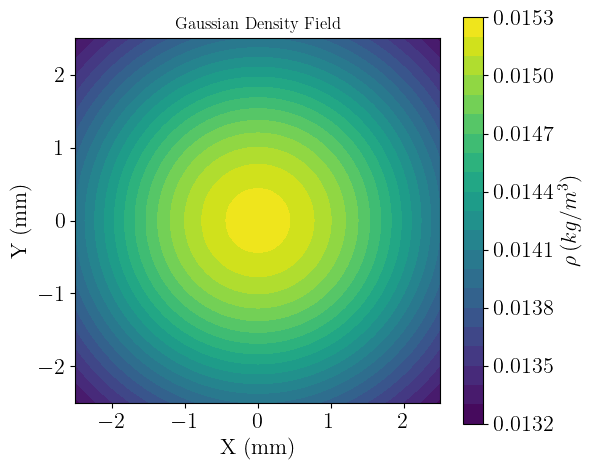

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# Gaussian density field function
# --------------------------------------------------
def create_gaussian_density_field(X, Y, rho0=1.225, delta_rho0=0.1,
                                  X0=0.0, Y0=0.0, sigma0=0.01):
    """
    Generate Gaussian density field: ρ(X,Y) = ρ0 + Δρ0 * exp(-((X-X0)^2 + (Y-Y0)^2)/(2*σ0^2))
    """
    r_squared = (X - X0)**2 + (Y - Y0)**2
    rho = rho0 + delta_rho0 * np.exp(-r_squared / (2 * sigma0**2))
    return rho


# --------------------------------------------------
# Load BOS data to get boundary coordinates
# --------------------------------------------------
input_file = "bos_pixel_displacements.txt"

print(f"Loading BOS data from: {input_file}")
data = np.loadtxt(input_file, comments='#')

X = data[:, 0]  # X coordinate (m)
Y = data[:, 1]  # Y coordinate (m)

# Get unique coordinates to determine bounds
X_unique = np.unique(X)
Y_unique = np.unique(Y)

# Extract boundary limits from the BOS data
x_min = X_unique.min()
x_max = X_unique.max()
y_min = Y_unique.min()
y_max = Y_unique.max()

print(f"Boundary limits from BOS data:")
print(f"  x_min = {x_min:.6e} m")
print(f"  x_max = {x_max:.6e} m")
print(f"  y_min = {y_min:.6e} m")
print(f"  y_max = {y_max:.6e} m")

# --------------------------------------------------
# Domain and grid
# --------------------------------------------------
# resolution
nx, ny = 51, 51

# coordinate arrays using bounds from BOS data
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)

# meshgrid
X_plot, Y_plot = np.meshgrid(x, y)

# --------------------------------------------------
# Density parameters
# --------------------------------------------------
rho0 = 1.225       # ambient air density (kg/m^3)
delta_rho0 = 0.3   # peak variation
X0, Y0 = 0.0, 0.0  # Gaussian center
sigma0 = 2.41e-3    # Gaussian width (m)

# --------------------------------------------------
# Generate density field
# --------------------------------------------------
rho_field = create_gaussian_density_field(
    X_plot, Y_plot,
    rho0=rho0, delta_rho0=delta_rho0,
    X0=X0, Y0=Y0,
    sigma0=sigma0
)

# --------------------------------------------------
# Plot Density field
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(6,5))

thickness_rho_field = 0.01 

im1 = ax.contourf(
    X_plot * 1000,  # convert to mm
    Y_plot * 1000,
    rho_field * thickness_rho_field,
    levels=20,
    cmap='viridis'
)

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_title('Gaussian Density Field')
ax.set_aspect('equal')

# limit axes to ±5 mm
# ax.set_xlim([-4.5, 4.5])
# ax.set_ylim([-4.5, 4.5])

cbar1 = plt.colorbar(im1, ax=ax)
cbar1.set_label(r'$\rho\,(kg/m^3)$')

plt.tight_layout()
plt.savefig('gpu_lens_density_field.png', dpi=150)
plt.show()

Loading BOS data from: bos_pixel_displacements.txt
Boundary limits from BOS data:
  x_min = -2.500000e-03 m
  x_max = 2.500000e-03 m
  y_min = -2.500000e-03 m
  y_max = 2.500000e-03 m

Loading reconstructed density from: density_field.txt
Reconstructed grid size: 51 x 51
Saved: gpu_lens_density_field.png

VERTICAL CENTERLINE ANALYSIS
Center index: x_idx = 25
Center coordinate: x = 0.0000 mm
Saved: centerline_comparison.png
Saved: centerline_absolute_error.png
Saved: centerline_percentage_error.png

SUMMARY STATISTICS

Vertical Centerline (X = 0.00 mm):
  Mean Absolute Error: 2.176380e-04 kg/m²
  Max Absolute Error:  3.705754e-04 kg/m²
  Mean Percentage Error: 1.451985 %
  Max Percentage Error:  2.430003 %
  Min Percentage Error:  0.0000 %

Saved centerline data to: centerline_reconstruction_51x51_res0.100mm.txt


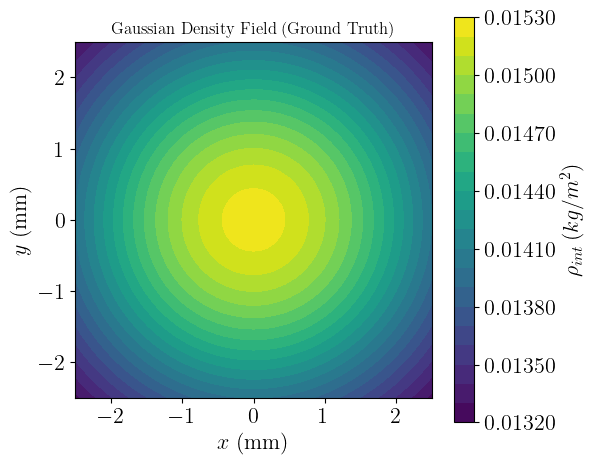

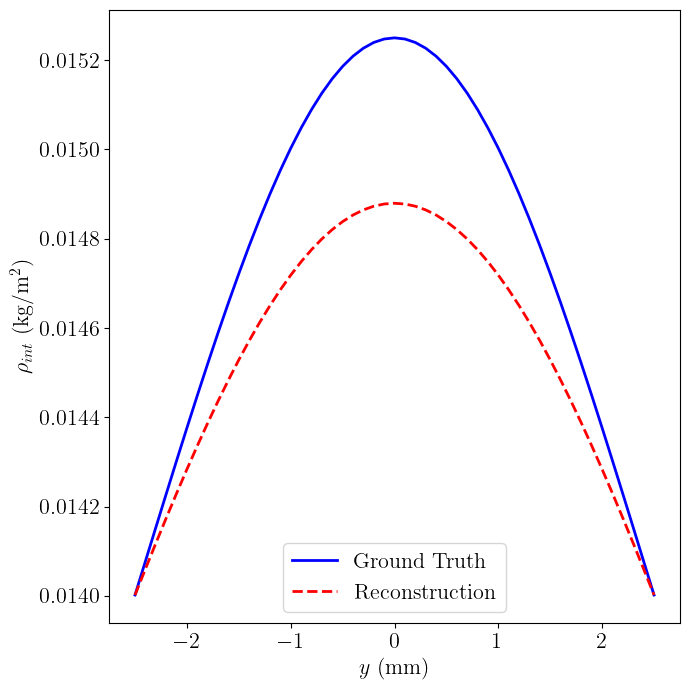

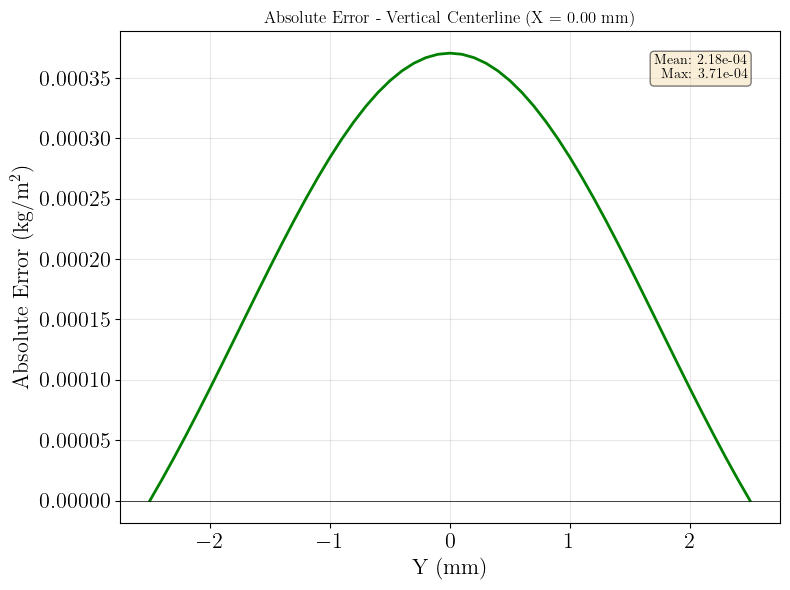

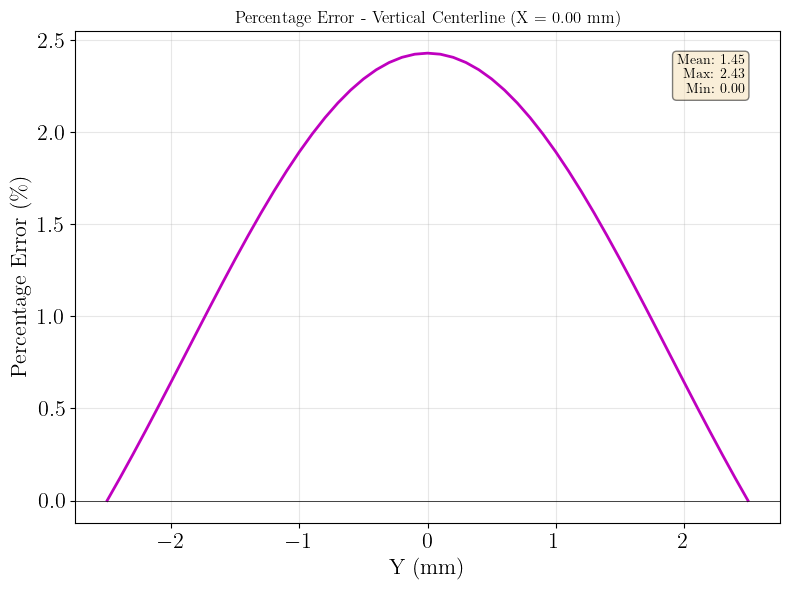

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# Gaussian density field function
# --------------------------------------------------
def create_gaussian_density_field(X, Y, rho0=1.225, delta_rho0=0.1,
                                  X0=0.0, Y0=0.0, sigma0=0.01):
    """
    Generate Gaussian density field: ρ(X,Y) = ρ0 + Δρ0 * exp(-((X-X0)^2 + (Y-Y0)^2)/(2*σ0^2))
    """
    r_squared = (X - X0)**2 + (Y - Y0)**2
    rho = rho0 + delta_rho0 * np.exp(-r_squared / (2 * sigma0**2))
    return rho

# --------------------------------------------------
# Load BOS data to get boundary coordinates
# --------------------------------------------------
input_file = "bos_pixel_displacements.txt"
print(f"Loading BOS data from: {input_file}")
data = np.loadtxt(input_file, comments='#')
X = data[:, 0]  # X coordinate (m)
Y = data[:, 1]  # Y coordinate (m)

# Get unique coordinates to determine bounds
X_unique = np.unique(X)
Y_unique = np.unique(Y)

# Extract boundary limits from the BOS data
x_min = X_unique.min()
x_max = X_unique.max()
y_min = Y_unique.min()
y_max = Y_unique.max()

print(f"Boundary limits from BOS data:")
print(f"  x_min = {x_min:.6e} m")
print(f"  x_max = {x_max:.6e} m")
print(f"  y_min = {y_min:.6e} m")
print(f"  y_max = {y_max:.6e} m")

# --------------------------------------------------
# Domain and grid
# --------------------------------------------------
# resolution
nx, ny = 51, 51

# coordinate arrays using bounds from BOS data
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)

# meshgrid
X_plot, Y_plot = np.meshgrid(x, y)

# --------------------------------------------------
# Density parameters
# --------------------------------------------------
rho0 = 1.225       # ambient air density (kg/m^3)
delta_rho0 = 0.3   # peak variation
X0, Y0 = 0.0, 0.0  # Gaussian center
sigma0 = 2.41e-3      # Gaussian width (m)
thickness_rho_field = 0.01 

# --------------------------------------------------
# Generate ground truth density field
# --------------------------------------------------
rho_field = create_gaussian_density_field(
    X_plot, Y_plot,
    rho0=rho0, delta_rho0=delta_rho0,
    X0=X0, Y0=Y0,
    sigma0=sigma0
)

# Apply thickness to get integrated density (ground truth)
ground_truth = rho_field * thickness_rho_field

# --------------------------------------------------
# Load reconstructed density field
# --------------------------------------------------
density_file = "density_field.txt"
print(f"\nLoading reconstructed density from: {density_file}")
recon_data = np.loadtxt(density_file, comments='#')

X_recon = recon_data[:, 0]  # X coordinate (m)
Y_recon = recon_data[:, 1]  # Y coordinate (m)
rho_recon = recon_data[:, 2]  # reconstructed density

# Get unique coordinates for reconstruction
X_recon_unique = np.unique(X_recon)
Y_recon_unique = np.unique(Y_recon)

Nx_recon = len(X_recon_unique)
Ny_recon = len(Y_recon_unique)

# Reshape to 2D array
rho_recon_2d = rho_recon.reshape((Nx_recon, Ny_recon))

print(f"Reconstructed grid size: {Nx_recon} x {Ny_recon}")

# --------------------------------------------------
# Generate ground truth on the same grid as reconstruction
# --------------------------------------------------
X_recon_mesh, Y_recon_mesh = np.meshgrid(X_recon_unique, Y_recon_unique, indexing='ij')

ground_truth_on_recon_grid = create_gaussian_density_field(
    X_recon_mesh, Y_recon_mesh,
    rho0=rho0, delta_rho0=delta_rho0,
    X0=X0, Y0=Y0,
    sigma0=sigma0
) * thickness_rho_field

# --------------------------------------------------
# Plot Density field (original plot)
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 5))
im1 = ax.contourf(
    X_plot * 1000,  # convert to mm
    Y_plot * 1000,
    ground_truth,
    levels=20,
    cmap='viridis'
)
ax.set_xlabel(r'$x$ (mm)')
ax.set_ylabel(r'$y$ (mm)')
ax.set_title('Gaussian Density Field (Ground Truth)')
ax.set_aspect('equal')
cbar1 = plt.colorbar(im1, ax=ax , format='%.5f')
cbar1.set_label(r'$\rho_{int}\,(kg/m^2)$')
plt.tight_layout()
plt.savefig('gpu_lens_density_field.png', dpi=150)
print("Saved: gpu_lens_density_field.png")

# --------------------------------------------------
# VERTICAL CENTERLINE ANALYSIS
# --------------------------------------------------
print("\n" + "="*70)
print("VERTICAL CENTERLINE ANALYSIS")
print("="*70)

# Find index closest to the center (X=0)
center_x_idx = np.argmin(np.abs(X_recon_unique - X0))

print(f"Center index: x_idx = {center_x_idx}")
print(f"Center coordinate: x = {X_recon_unique[center_x_idx]*1000:.4f} mm")

# Extract vertical centerline data (along Y at X=0)
recon_vertical = rho_recon_2d[center_x_idx, :]
truth_vertical = ground_truth_on_recon_grid[center_x_idx, :]
y_vertical = Y_recon_unique * 1000  # convert to mm

# Compute errors
abs_error_vertical = np.abs(recon_vertical - truth_vertical)

with np.errstate(divide='ignore', invalid='ignore'):
    pct_error_vertical = np.abs((recon_vertical - truth_vertical) / truth_vertical) * 100
    pct_error_vertical = np.nan_to_num(pct_error_vertical, nan=0.0, posinf=0.0, neginf=0.0)

# --------------------------------------------------
# Plot 1: Comparison - Reconstruction vs Ground Truth
# --------------------------------------------------
fig1, ax1 = plt.subplots(figsize=(7, 7))
ax1.plot(y_vertical, truth_vertical, 'b-', linewidth=2, label='Ground Truth')
ax1.plot(y_vertical, recon_vertical, 'r--', linewidth=2, label='Reconstruction')
ax1.set_xlabel(r'$y$ (mm)')
ax1.set_ylabel(r'$\rho_{int}$ (kg/m$^2$)')
# ax1.set_title(f'Vertical Centerline Comparison (X = {X_recon_unique[center_x_idx]*1000:.2f} mm)')
ax1.legend()
ax1.grid(False)
plt.tight_layout()
plt.savefig('centerline_comparison.png', dpi=150)
print("Saved: centerline_comparison.png")

# --------------------------------------------------
# Plot 2: Absolute Error
# --------------------------------------------------
fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.plot(y_vertical, abs_error_vertical, 'g-', linewidth=2)
ax2.set_xlabel('Y (mm)')
ax2.set_ylabel(r'Absolute Error (kg/m$^2$)')
ax2.set_title(f'Absolute Error - Vertical Centerline (X = {X_recon_unique[center_x_idx]*1000:.2f} mm)')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

# Add statistics
mean_err = np.mean(abs_error_vertical)
max_err = np.max(abs_error_vertical)
ax2.text(0.95, 0.95, f'Mean: {mean_err:.2e}\nMax: {max_err:.2e}',
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('centerline_absolute_error.png', dpi=150)
print("Saved: centerline_absolute_error.png")

# --------------------------------------------------
# Plot 3: Percentage Error
# --------------------------------------------------
fig3, ax3 = plt.subplots(figsize=(8, 6))
ax3.plot(y_vertical, pct_error_vertical, 'm-', linewidth=2)
ax3.set_xlabel('Y (mm)')
ax3.set_ylabel('Percentage Error (\\%)')
ax3.set_title(f'Percentage Error - Vertical Centerline (X = {X_recon_unique[center_x_idx]*1000:.2f} mm)')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

# Add statistics
mean_pct = np.mean(pct_error_vertical)
max_pct = np.max(pct_error_vertical)
min_pct = np.min(pct_error_vertical)
ax3.text(0.95, 0.95, f'Mean: {mean_pct:.2f}%\nMax: {max_pct:.2f}%\nMin: {min_pct:.2f}%',
         transform=ax3.transAxes, fontsize=10, verticalalignment='top',
         horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('centerline_percentage_error.png', dpi=150)
print("Saved: centerline_percentage_error.png")

# --------------------------------------------------
# Print summary statistics
# --------------------------------------------------
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(f"\nVertical Centerline (X = {X_recon_unique[center_x_idx]*1000:.2f} mm):")
print(f"  Mean Absolute Error: {mean_err:.6e} kg/m²")
print(f"  Max Absolute Error:  {max_err:.6e} kg/m²")
print(f"  Mean Percentage Error: {mean_pct:.6f} %")
print(f"  Max Percentage Error:  {max_pct:.6f} %")
print(f"  Min Percentage Error:  {min_pct:.4f} %")

# --------------------------------------------------
# Save reconstruction data to txt file
# --------------------------------------------------
# Get spatial resolution from input BOS data
Nx_input = len(X_unique)
Ny_input = len(Y_unique)
grid_spacing_input_mm = (X_unique[1] - X_unique[0]) * 1000  # in mm

# Create filename based on input file spatial resolution
output_filename = f"centerline_reconstruction_{Nx_input}x{Ny_input}_res{grid_spacing_input_mm:.3f}mm.txt"

# Save Y location (mm), reconstruction, ground truth, absolute error, percentage error
output_data = np.column_stack([
    y_vertical,           # Y location in mm
    recon_vertical,       # Reconstruction
    truth_vertical,       # Ground truth
    abs_error_vertical,   # Absolute error
    pct_error_vertical    # Percentage error
])

header = (f"Vertical Centerline Data (X = {X_recon_unique[center_x_idx]*1000:.4f} mm)\n"
          f"Input grid resolution: {Nx_input} x {Ny_input}\n"
          f"Input spatial resolution: {grid_spacing_input_mm:.6f} mm\n"
          f"Y(mm) Reconstruction(kg/m^2) GroundTruth(kg/m^2) AbsError(kg/m^2) PctError(%)")

np.savetxt(output_filename, output_data, header=header, fmt='%.8e')
print(f"\nSaved centerline data to: {output_filename}")

plt.show()